In [2]:
# Import necessary libraries
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt

In [17]:
# Load the data
df = pd.read_csv('Combined_Secondary_Defense.csv')
metric = 'Current_PFF'  # Metric to predict

In [18]:
print(df.columns)

Index(['Unnamed: 0', 'Team', 'Year', 'Position', 'Value_cap_space',
       'Value_draft_data', 'Current_AV', 'Current_PFF', 'Total DVOA',
       'win-loss-pct',
       ...
       'Previous_snap_counts_slot', 'Previous_stops', 'Previous_tackles',
       'Previous_tackles_for_loss', 'Previous_targets',
       'Previous_total_pressures', 'Previous_touchdowns', 'Previous_yards',
       'Previous_yards_after_catch', 'Previous_yards_per_reception'],
      dtype='object', length=117)


In [19]:
# Drop unnecessary columns
columns_to_drop = ['Unnamed: 0']
df = df.drop(columns=columns_to_drop)

In [20]:
# Sort data by Team and Year
df = df.sort_values(by=['Team', 'Year'])
print(df.head())

      Team  Year Position  Value_cap_space  Value_draft_data  Current_AV  \
17   49ers  2019       DB        15.313496        270.589442        35.0   
50   49ers  2020       DB        13.657921        257.525536        36.0   
70   49ers  2021       DB         7.895890        247.080988        34.0   
123  49ers  2022       DB        11.383285        101.033420        45.0   
12   Bears  2019       DB        19.373007        241.860963        43.0   

     Current_PFF Total DVOA  win-loss-pct  Net EPA  ...  \
17     74.600742     27.90%      0.812500    0.216  ...   
50     66.704119      5.40%      0.375000    0.025  ...   
70     62.219454     19.50%      0.588235    0.081  ...   
123    69.627066     27.60%      0.764706    0.196  ...   
12     66.382439     -2.10%      0.500000   -0.032  ...   

     Previous_snap_counts_slot  Previous_stops  Previous_tackles  \
17                  105.954181        8.742204         29.438840   
50                  120.219801       12.132261      

In [21]:
team_data = df.groupby('Team')

In [24]:
import numpy as np

sequences = []
targets = []

# Iterate over each team and its respective data
for team, group in team_data:
    # Ensure the team has at least 4 years of data
    if len(group) >= 4:
        print(f"Processing team: {team}, data length: {len(group)}")  # Debugging: check length of data for each team
        
        # Iterate through the data to create sequences for 3 years
        for i in range(len(group) - 3):
            # Select the relevant columns for the sequence
            sequence = group.iloc[i:i+3][['Previous_grades_tackle', 'Previous_AV',
                                            'Previous_PFF',
                                            'Previous_franchise_id',
                                            'Previous_grades_run_defense',
                                            'Previous_grades_coverage_defense',
                                            'Previous_tackles_for_loss']]  # Add more columns if needed
            
            # The target is the next year's Current_PFF
            target = group.iloc[i+3]['Current_PFF']  
            
            sequences.append(sequence.values)  # Add the sequence to the list
            targets.append(target)  # Add the target to the list

# Convert lists to numpy arrays
X = np.array(sequences)
y = np.array(targets)



print(f"Total sequences generated: {len(sequences)}")
print(f"X shape: {X.shape}, y shape: {y.shape}")

Processing team: 49ers, data length: 4
Processing team: Bears, data length: 4
Processing team: Bengals, data length: 4
Processing team: Bills, data length: 4
Processing team: Broncos, data length: 4
Processing team: Browns, data length: 4
Processing team: Buccaneers, data length: 4
Processing team: Cardinals, data length: 4
Processing team: Chargers, data length: 4
Processing team: Chiefs, data length: 4
Processing team: Colts, data length: 4
Processing team: Commanders, data length: 4
Processing team: Cowboys, data length: 4
Processing team: Dolphins, data length: 4
Processing team: Eagles, data length: 4
Processing team: Falcons, data length: 4
Processing team: Giants, data length: 4
Processing team: Jaguars, data length: 4
Processing team: Jets, data length: 4
Processing team: Lions, data length: 4
Processing team: Packers, data length: 4
Processing team: Panthers, data length: 4
Processing team: Patriots, data length: 4
Processing team: Raiders, data length: 4
Processing team: Rams

In [39]:
# Check shape before reshaping
print(X)
print(X.shape)

# Reshape X to (samples, timesteps, features)
X = X.reshape(X.shape[0], 3, -1)  # 3 years per sequence, features will be inferred

print(X.shape)  # Should now be (samples, 3, features)
print(X)

scaler = StandardScaler()
X = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

[[[60.18003406 29.         56.96510714 28.         67.75277437
   55.08925533  1.80849409]
  [59.34648658 35.         74.60074166 28.         69.56141715
   73.95167181  1.79530333]
  [65.4289868  36.         66.70411885 28.         70.59421169
   64.43871668  0.8834877 ]]

 [[68.34141273 49.         83.15682879  6.         73.21140016
   83.42233101  1.6032921 ]
  [61.86186275 43.         66.38243854  6.         68.44952585
   65.93286816  1.59863093]
  [58.26601136 33.         60.72455662  6.         60.43048506
   60.20632252  0.58751767]]

 [[58.82703144 24.         70.5970905   7.         69.36530587
   71.49349449  1.18867841]
  [54.12743187 27.         58.06420444  7.         54.97966047
   59.00410277  1.76290475]
  [67.65442276 30.         69.52536358  7.         65.82612226
   67.42535476  1.97082946]]

 [[58.15197266 35.         69.94821906  4.         62.06269992
   71.55616136  2.11372616]
  [58.97224099 51.         72.72997731  4.         66.85490119
   72.17233736  2.530

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, SimpleRNN, MultiHeadAttention, LayerNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [42]:
# Define the input layer
inputs = Input(shape=(3, 7))  # 3 time steps, 8 features

# Add a Dense layer before the attention to create more variability in the input
dense_input = Dense(16, activation='relu')(inputs)

# Add MultiHeadAttention layer
attention_output = MultiHeadAttention(num_heads=2, key_dim=8)(dense_input, dense_input)

# Add Layer Normalization for stability
attention_output = LayerNormalization()(attention_output)

# Add RNN layer to capture temporal dependencies
rnn_output = SimpleRNN(units=50, activation='relu')(attention_output)

# Add Dropout to prevent overfitting
rnn_output = Dropout(0.2)(rnn_output)

# Output layer for predicting Current PFF
output = Dense(1)(rnn_output)

# Define the model
model = Model(inputs=inputs, outputs=output)

In [43]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [44]:
# Early stopping callback to monitor validation loss
#early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

Epoch 1/5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 4164.8350 - val_loss: 4185.9229
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4116.5669 - val_loss: 4094.1384
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4014.7053 - val_loss: 4002.9480
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3885.1086 - val_loss: 3902.0618
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3838.4553 - val_loss: 3788.0273


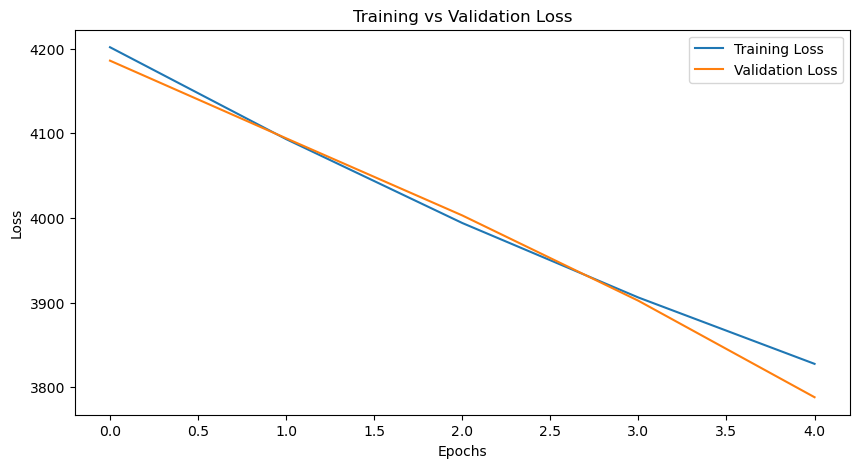

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
R² Score: -333.1198


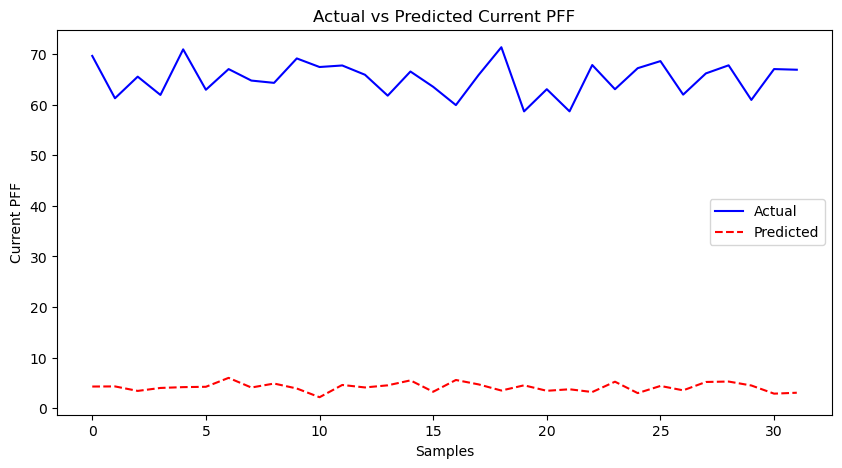

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3745.1018 - val_loss: 3647.2014
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3530.0833 - val_loss: 3460.7278
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3360.2715 - val_loss: 3222.5281
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3031.0332 - val_loss: 2916.7493
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2722.1067 - val_loss: 2534.7932
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2441.6589 - val_loss: 2073.8167
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1854.9485 - val_loss: 1541.1328
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1304.9155 - val_loss: 967.4844
Epoch 9/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 773.7778 - val_loss: 442.6051
Epoch 10/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 302.4169 - val_loss: 94.9883


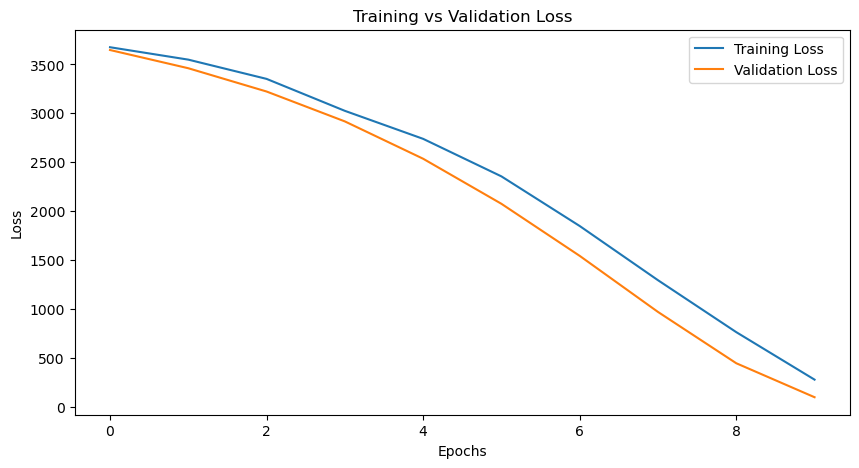

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
R² Score: -5.9992


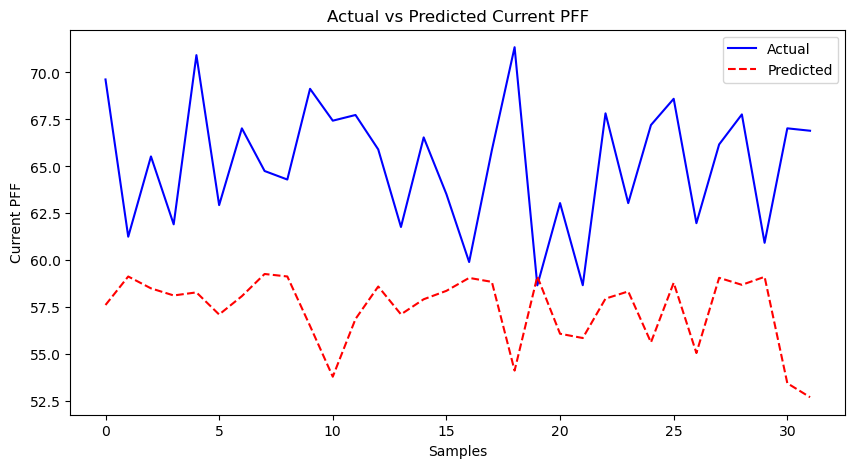

Epoch 1/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 118.6183 - val_loss: 19.7415
Epoch 2/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 107.8891 - val_loss: 95.0817
Epoch 3/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 150.9203 - val_loss: 77.9533
Epoch 4/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 172.3888 - val_loss: 21.1270
Epoch 5/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 101.9392 - val_loss: 14.6467
Epoch 6/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 77.6482 - val_loss: 50.0510
Epoch 7/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 99.5058 - val_loss: 63.7761
Epoch 8/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 128.1839 - val_loss: 40.7448
Epoch 9/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 74.4574 - val_loss: 12.6784
Epoch 10/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 38.3486 - val_loss: 11.8874
Epoch 11/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 46.8736 - val_loss: 17.5492
Epoch 12/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 94.1389 - v

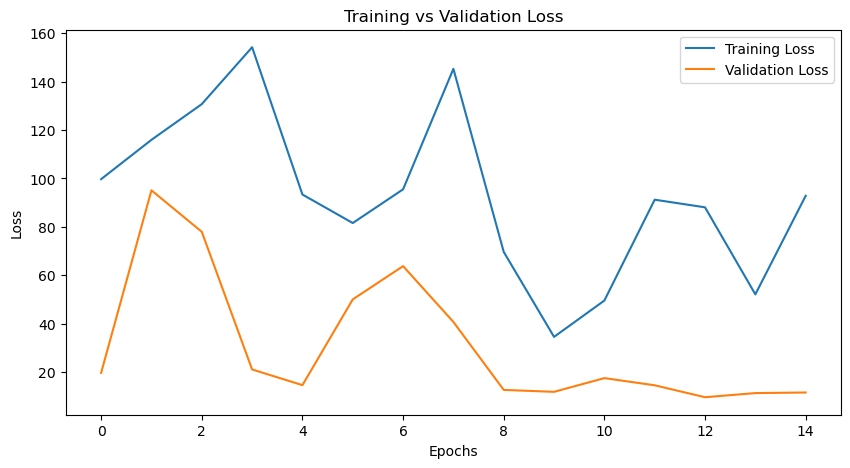

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
R² Score: -0.1762


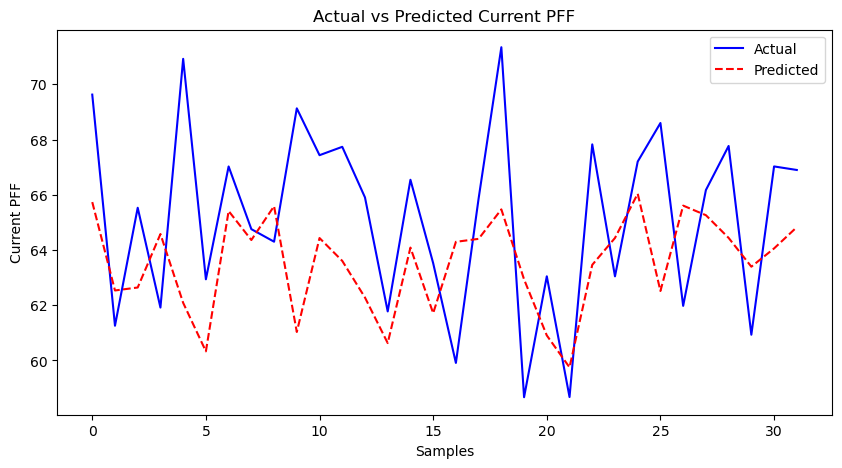

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 55.7093 - val_loss: 11.1621
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 92.8475 - val_loss: 10.2077
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 70.4564 - val_loss: 10.0471
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 55.9510 - val_loss: 10.7311
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 39.3494 - val_loss: 10.2674
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 91.1592 - val_loss: 11.3325
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 54.5455 - val_loss: 12.0920
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 58.2455 - val_loss: 11.0428
Epoch 9/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 52.3576 - val_loss: 10.8664
Epoch 10/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 95.3949 - val_loss: 11.2643
Epoch 11/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 55.0793 - val_loss: 13.7195
Epoch 12/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 74.7826 - val_los

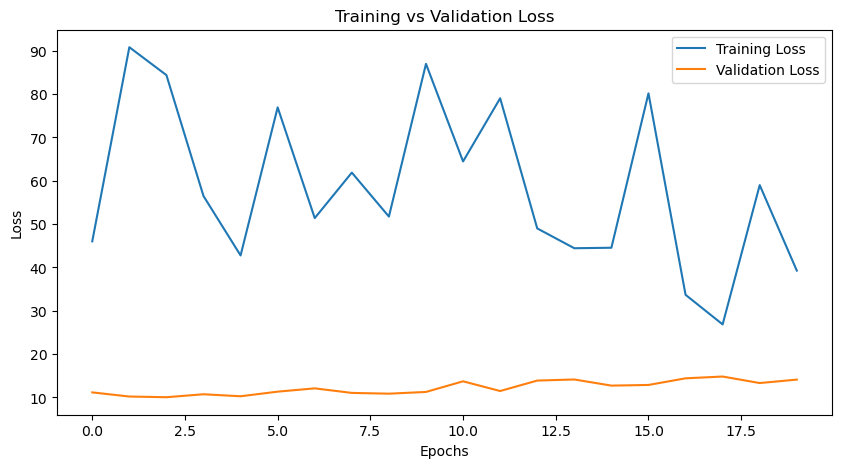

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
R² Score: 0.0916


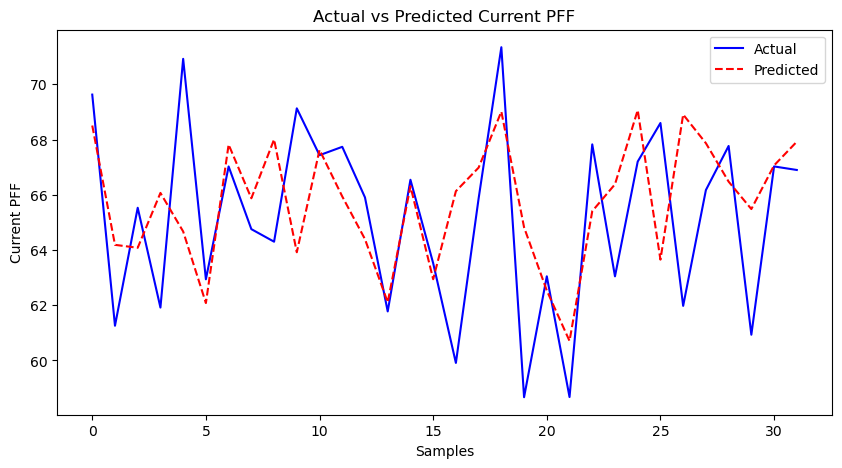

Epoch 1/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 80.7455 - val_loss: 13.2055
Epoch 2/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 65.4240 - val_loss: 13.2324
Epoch 3/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 33.5367 - val_loss: 14.5335
Epoch 4/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 66.3251 - val_loss: 18.7041
Epoch 5/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 54.8719 - val_loss: 20.7410
Epoch 6/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 39.8139 - val_loss: 13.1299
Epoch 7/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 26.5590 - val_loss: 16.9728
Epoch 8/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 39.7274 - val_loss: 19.9313
Epoch 9/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 63.5451 - val_loss: 20.2058
Epoch 10/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 48.8412 - val_loss: 12.5134
Epoch 11/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 34.1680 - val_loss: 14.3097
Epoch 12/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 62.9997 - val_los

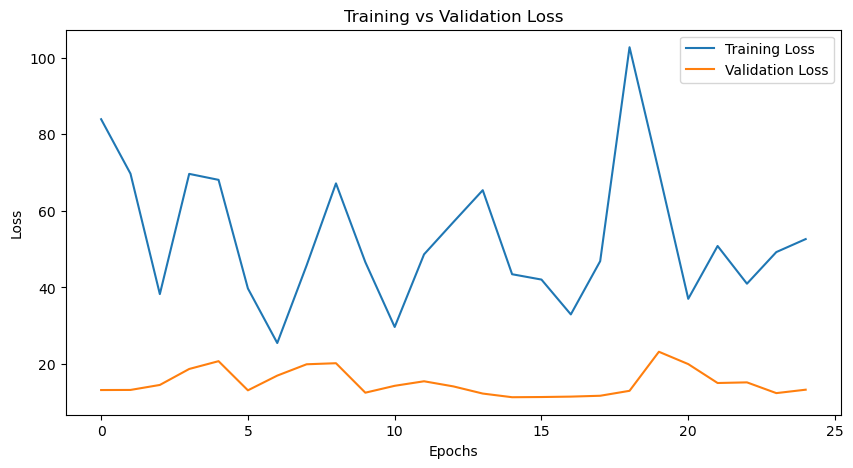

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
R² Score: -0.1373


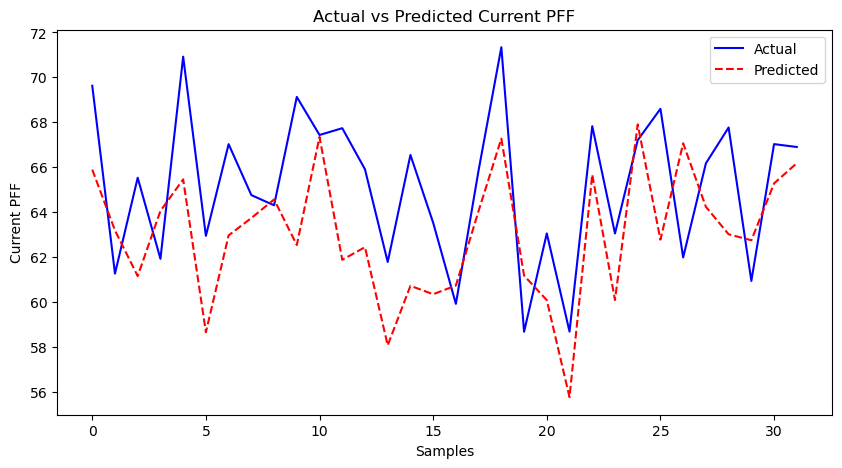

Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 47.5442 - val_loss: 14.3106
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 51.9852 - val_loss: 15.5628
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 56.9301 - val_loss: 14.2041
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 42.3864 - val_loss: 11.7792
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 31.2968 - val_loss: 12.3651
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 83.5477 - val_loss: 14.9902
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 61.1650 - val_loss: 12.0683
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 68.2540 - val_loss: 12.7402
Epoch 9/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 47.2268 - val_loss: 12.9281
Epoch 10/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 54.5035 - val_loss: 12.7253
Epoch 11/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 24.3717 - val_loss: 12.7888
Epoch 12/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 60.2591 - val_los

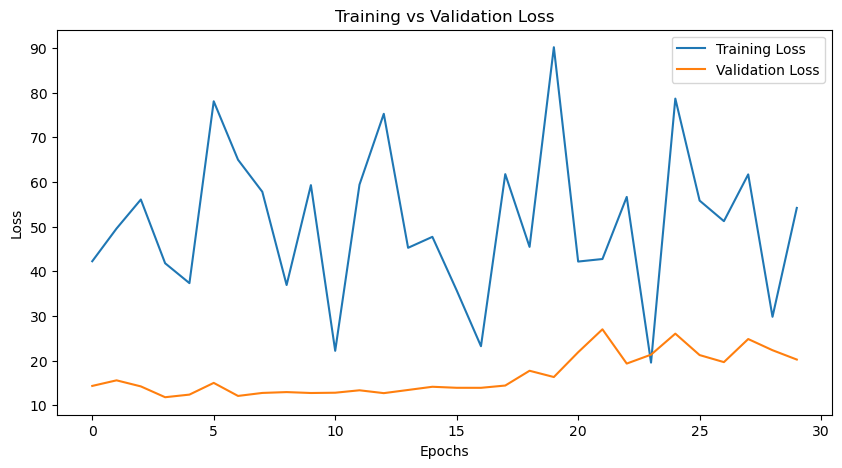

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
R² Score: 0.2014


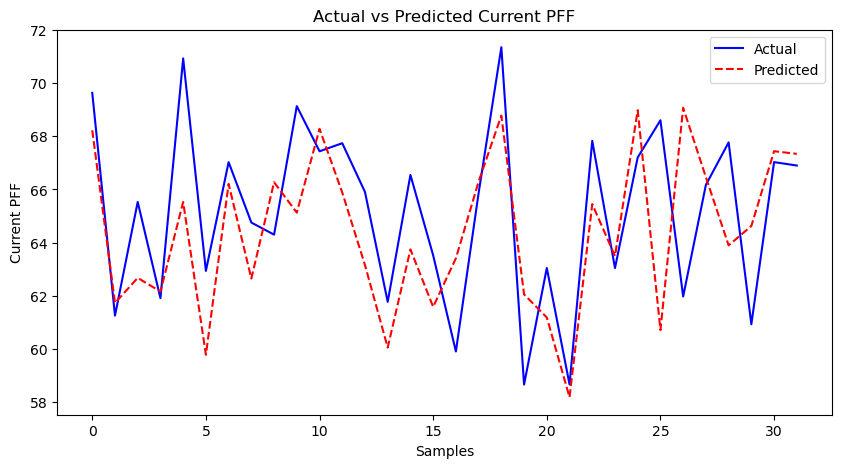

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 34.3737 - val_loss: 21.4018
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 31.2908 - val_loss: 19.7536
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 74.4236 - val_loss: 18.9081
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 28.3977 - val_loss: 18.1003
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 52.2572 - val_loss: 17.0293
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 35.7284 - val_loss: 16.3283
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 49.3521 - val_loss: 16.1316
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 38.2742 - val_loss: 16.6349
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 63.5428 - val_loss: 17.1390
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 49.4216 - val_loss: 16.9402
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 39.6358 - val_loss: 18.9155
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 39.9184 - val_los

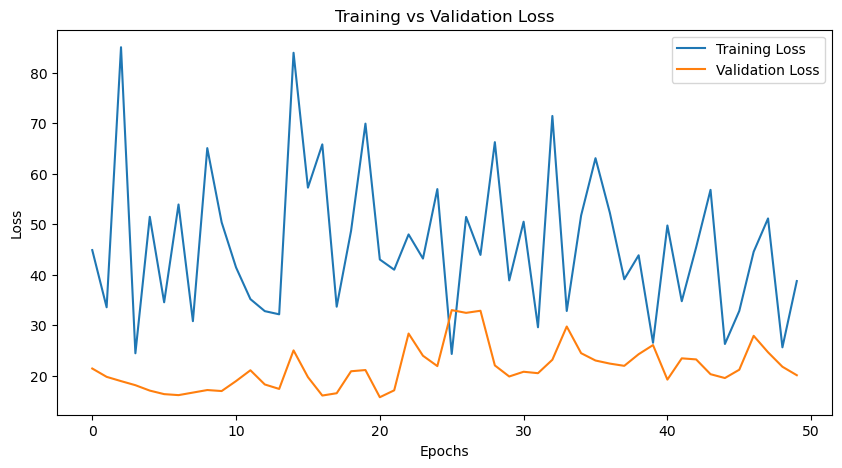

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
R² Score: 0.4580


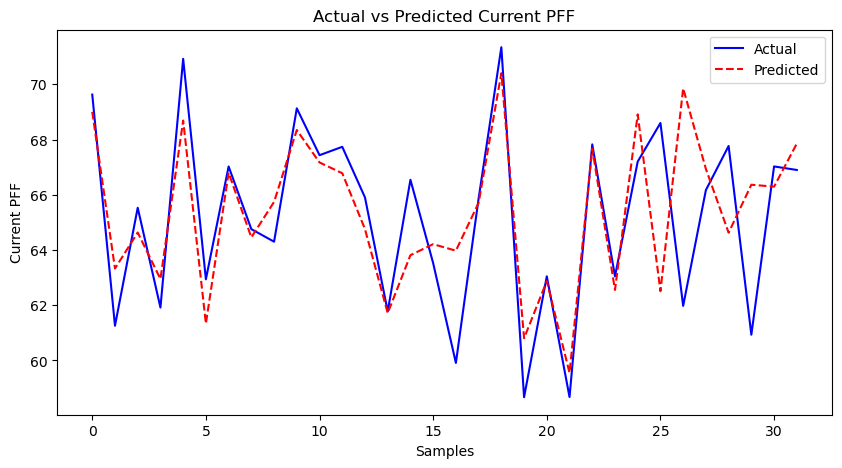

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 50.4568 - val_loss: 23.4541
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 40.4045 - val_loss: 28.3314
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 71.0396 - val_loss: 18.3193
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 37.5539 - val_loss: 26.5540
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 58.6076 - val_loss: 43.3946
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 67.9946 - val_loss: 28.2500
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 35.8797 - val_loss: 18.1329
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 25.3706 - val_loss: 28.8136
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 43.2620 - val_loss: 24.9546
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 27.9464 - val_loss: 21.8568
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 46.6900 - val_loss: 20.2058
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 50.79

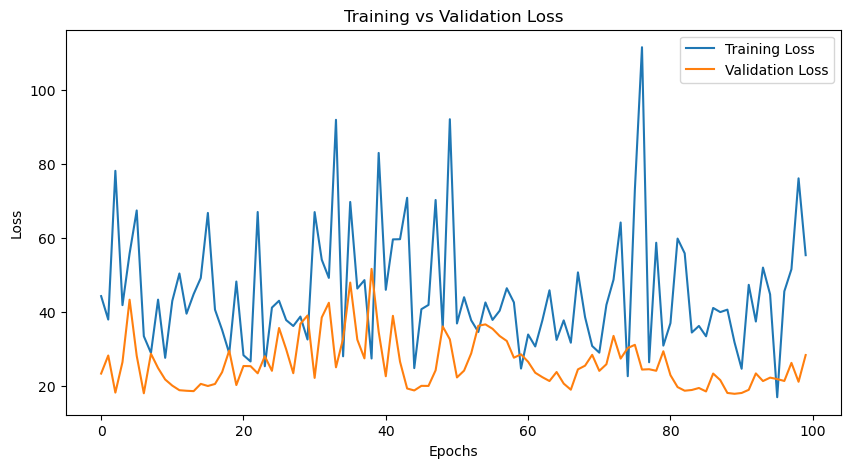

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
R² Score: -0.6561


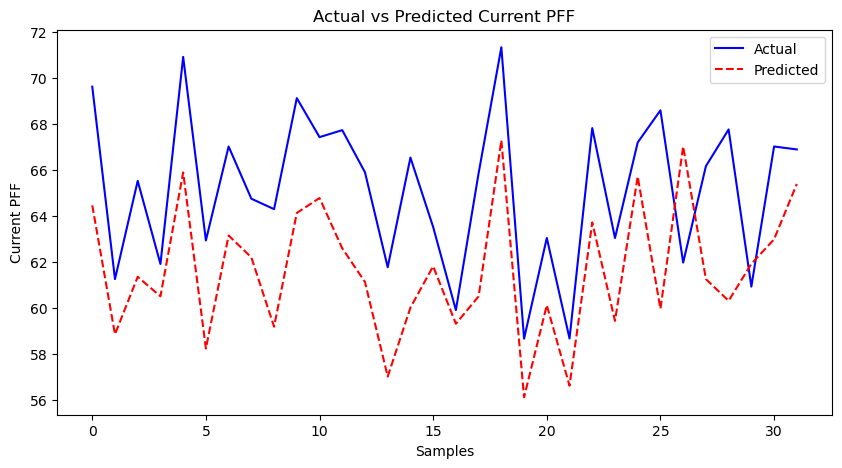

Epoch 1/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 39.3581 - val_loss: 37.4786
Epoch 2/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 38.5457 - val_loss: 20.0276
Epoch 3/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 27.6514 - val_loss: 22.3017
Epoch 4/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 50.2792 - val_loss: 27.4127
Epoch 5/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 38.5649 - val_loss: 19.0996
Epoch 6/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 34.3633 - val_loss: 23.0856
Epoch 7/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 54.2735 - val_loss: 23.6617
Epoch 8/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 42.7461 - val_loss: 22.3095
Epoch 9/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 41.7868 - val_loss: 21.4895
Epoch 10/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 52.3243 - val_loss: 23.3882
Epoch 11/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 45.5878 - val_loss: 26.8455
Epoch 12/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 33.35

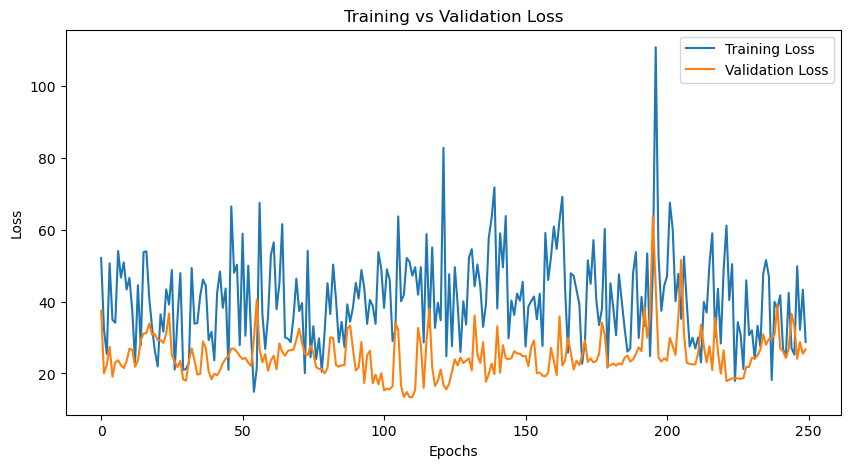

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
R² Score: 0.3312


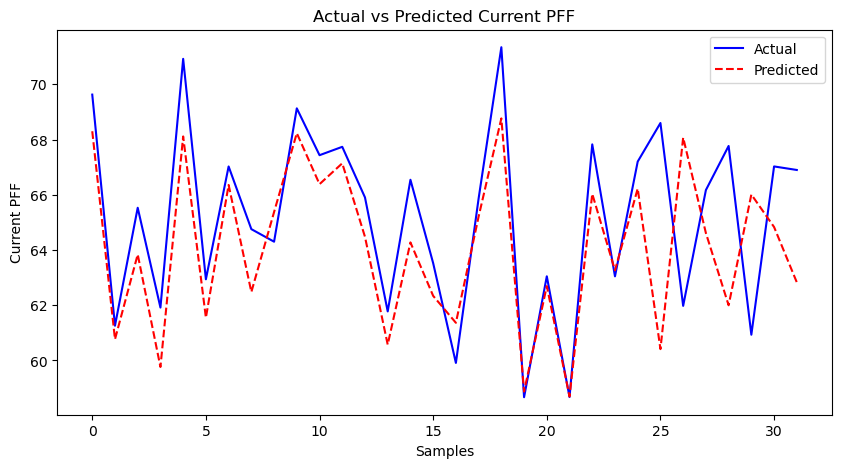

In [45]:
# Train the model
#history = model.fit(X, y, epochs=100, batch_size=8, validation_split=0.2, callbacks=[early_stopping])
epoch_list = [5, 10, 15, 20, 25, 30, 50, 100, 250]
for e in epoch_list:
    history = model.fit(X, y, epochs=e, batch_size=8, validation_split=0.2)
    # Plot training & validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    # Make predictions on the test set
    y_pred = model.predict(X)
    from sklearn.metrics import r2_score

    # Calculate R² score
    r2 = r2_score(y, y_pred)

    # Print R² score
    print(f"R² Score: {r2:.4f}")
    # Plot actual vs predicted values
    plt.figure(figsize=(10, 5))
    plt.plot(y, label='Actual', color='blue')
    plt.plot(y_pred, label='Predicted', color='red', linestyle='dashed')
    plt.title('Actual vs Predicted Current PFF')
    plt.xlabel('Samples')
    plt.ylabel('Current PFF')
    plt.legend()
    plt.show()